# Training a MACE model


In this notebook, the flow of training a MACE model is detailed step by step.



In [9]:
import matplotlib.pyplot    as plt
import numpy                as np
import torch
from time                   import time
import datetime             as dt
from tqdm                   import tqdm

from pathlib import Path
import sys

parentpath = str(Path().cwd())+'/'

print(parentpath)

sys.path.append(parentpath)

import src.mace.CSE_0D.dataset  as ds
import src.mace.train           as train
import src.mace.test            as test
import src.mace.load            as load
import src.mace.mace            as mace
from src.mace.loss              import Loss
import src.mace.loss            as loss
import src.mace.utils           as utils
from src.mace.input             import Input

specs_dict, idx_specs = utils.get_specs()

%reload_ext autoreload
%autoreload 2

/STER/silkem/MACE/


## Setting up

>***Note***:
>If you are training the architecture with your own data, you can set up the model in the following way. However, if you will follow the notebook, we will load a pre-trained model to continue the training, just for tutorial purposes. Then, skip the cells on "Set up the model".


### Naming the model
The default model to name the model is with the date and time of training. This can be adjusted with changing the parameter name.




In [10]:
now = dt.datetime.now()
name = str(now.strftime("%Y%m%d")+'_'+now.strftime("%H%M%S"))

path = parentpath + 'model/'+name

print(path)

/STER/silkem/MACE/model/20241021_165509


Make directories to store output and trained model.



In [11]:
utils.makeOutputDir(path)
utils.makeOutputDir(path+'/nn')

'/STER/silkem/MACE/model/20241021_165509/nn'

### Reading input file
Fill in the name of the input file for arg.

For tutorial purposes, the amount of training data and training epochs is limited in this example.

In [12]:
arg = 'example'

In [50]:
infile = parentpath+'input/'+arg+'.in'
input = Input(infile, name)
meta = input.make_meta(path)
input.print()

------------------------------
Name: 20241021_165509
------------------------------
     inputfile: /STER/silkem/MACE/input/example.in
      # hidden: 1
       ae type: simple
# z dimensions: 8
        scheme: int
  # evolutions: 16
     loss type: abs_idn
      # epochs: 15
 learning rate: 0.0001



### Set up Pytorch

In [14]:
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 1
kwargs = {'num_workers': 1, 'pin_memory': True}

### Set up the model


Make the model, randomly initialised.



In [15]:
model = mace.Solver(n_dim=input.n_dim, p_dim=4,z_dim = input.z_dim,
                    nb_hidden=input.nb_hidden, ae_type=input.ae_type,
                    scheme=input.scheme, nb_evol=input.nb_evol,
                    path = path,
                    DEVICE = DEVICE,
                    lr=input.lr )

num_params = utils.count_parameters(model)
print(f'\nThe model has {num_params} trainable parameters')


The model has 284692 trainable parameters


### Set up training & testing data

Load the train, validation, and test data sets.

In [51]:
traindata, testdata, data_loader, test_loader = ds.get_data(dt_fract=input.dt_fract,
                                                            nb_samples=input.nb_samples, batch_size=batch_size,
                                                            nb_test=input.nb_test,kwargs=kwargs)

> Train state: True
Found paths: 5
Selected paths: 4
Selected test paths: 1


> Train state: False
Found paths: 5
Selected paths: 4
Selected test paths: 4


Dataset:
------------------------------
  total # of samples: 4
#   training samples: 2
# validation samples: 2
               ratio: 0.5
     #  test samples: 1


## Loading the pre-trained model


Setting the directory of the model.



In [35]:
outloc  = parentpath+'model/'
dirname = '20240604_160152'     ## analogue to int4 model of the paper

Loading the pre-trained model.



In [37]:
trained = load.Trained_MACE(outloc=outloc, dirname=dirname, epoch=5)
meta = trained.get_meta()
model = trained.model

The model has 284692 trainable parameters


## Training the model

Training the model in [Maes et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024arXiv240503274M/abstract) happens it two stages:

1. For the first few epochs (input.ini_epochs) the models is trained with unscaled losses.
2. The losses of the model are rescaled, normalised based in the losses in the first few epochs.

### Stage 1
Initialise loss.

In [40]:
norm, fract = loss.initialise()

trainloss = Loss(norm, fract, input.losstype)
testloss  = Loss(norm, fract, input.losstype)

Train the model & time the training.

In [42]:
len('/csfrac_smooth.out/')

19


Integrated training scheme in use.

>>> Training model...
Epoch 1 complete! 	Average training loss:  0 	Average validation loss:  0.00048
              time [mins]:  20.38
Epoch 2 complete! 	Average training loss:  0 	Average validation loss:  0.0009
              time [mins]:  20.4
Epoch 3 complete! 	Average training loss:  0 	Average validation loss:  0.00134
              time [mins]:  20.43
Epoch 4 complete! 	Average training loss:  0.0008 	Average validation loss:  0.00096
              time [mins]:  20.45
Epoch 5 complete! 	Average training loss:  0.00047 	Average validation loss:  0.00061
              time [mins]:  20.47

 	DONE!


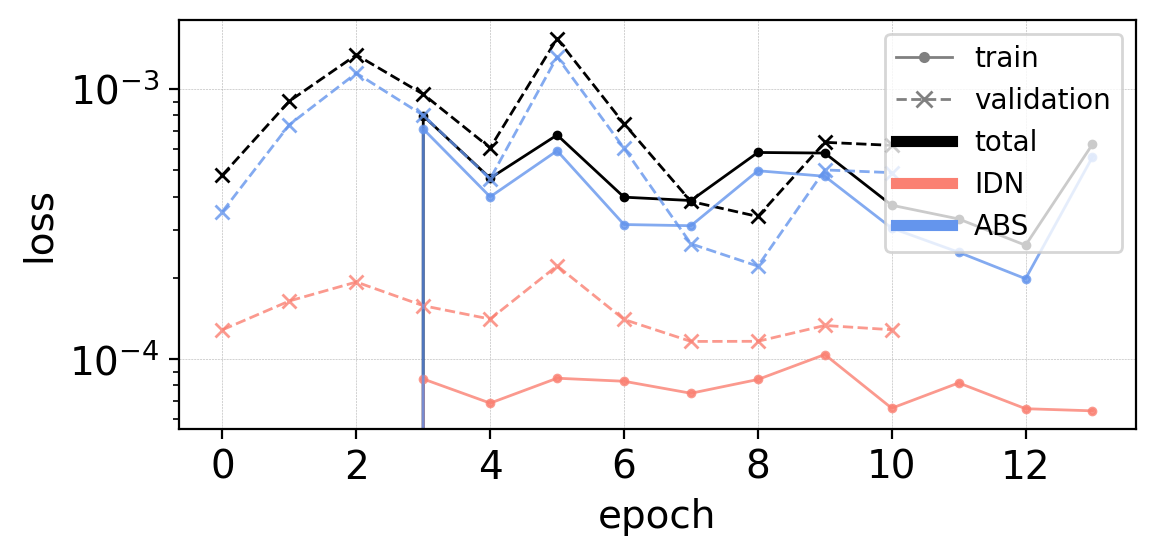

In [47]:
tic = time()
train.train(model,
            data_loader, test_loader,
            end_epochs = input.ini_epochs,
            trainloss=trainloss, testloss=testloss)
toc = time()
train_time1 = toc-tic

### Stage 2
Normalise losses based on the past losses, and (optional) scale losses, given by parameter fract.

In [48]:
fract = input.get_facts()
trainloss.change_fract(fract)
testloss.change_fract(fract)

new_norm = trainloss.normalise()
testloss.change_norm(new_norm)

Continue the training.




Integrated training scheme in use.

>>> Training model...
Epoch 6 complete! 	Average training loss:  0.00068 	Average validation loss:  0.00154
              time [mins]:  22.0
Epoch 7 complete! 	Average training loss:  0.0004 	Average validation loss:  0.00074
              time [mins]:  22.02
Epoch 8 complete! 	Average training loss:  0.00039 	Average validation loss:  0.00038
              time [mins]:  22.12
Epoch 9 complete! 	Average training loss:  0.00058 	Average validation loss:  0.00034
              time [mins]:  22.15
Epoch 10 complete! 	Average training loss:  0.00058 	Average validation loss:  0.00064
              time [mins]:  22.17
Epoch 11 complete! 	Average training loss:  0.00037 	Average validation loss:  0.00062
              time [mins]:  22.2
Epoch 12 complete! 	Average training loss:  0.00033 	Average validation loss:  0.00136
              time [mins]:  22.23
Epoch 13 complete! 	Average training loss:  0.00026 	Average validation loss:  0.00074
              

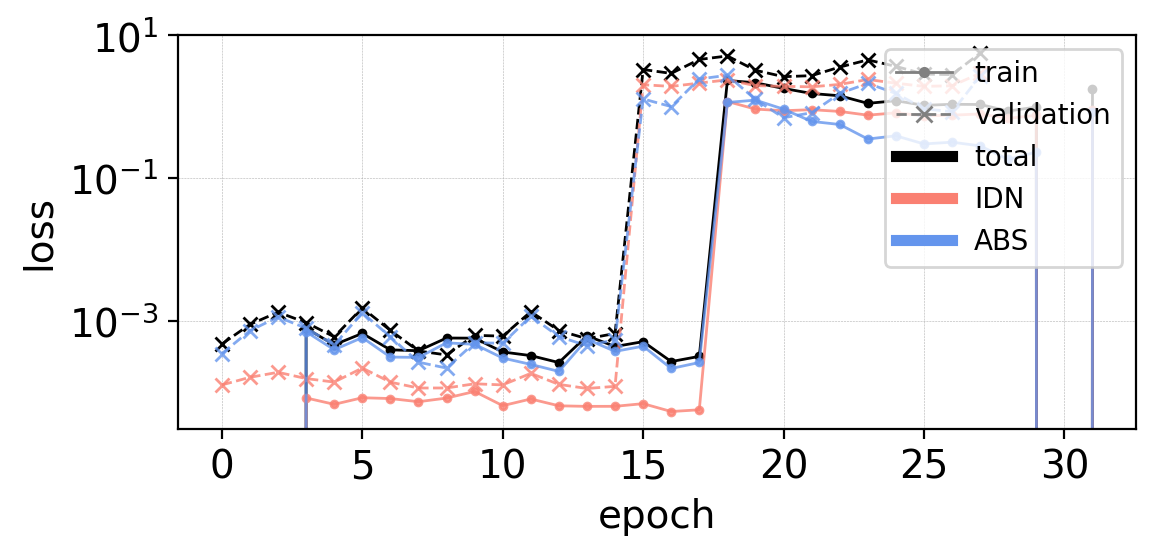

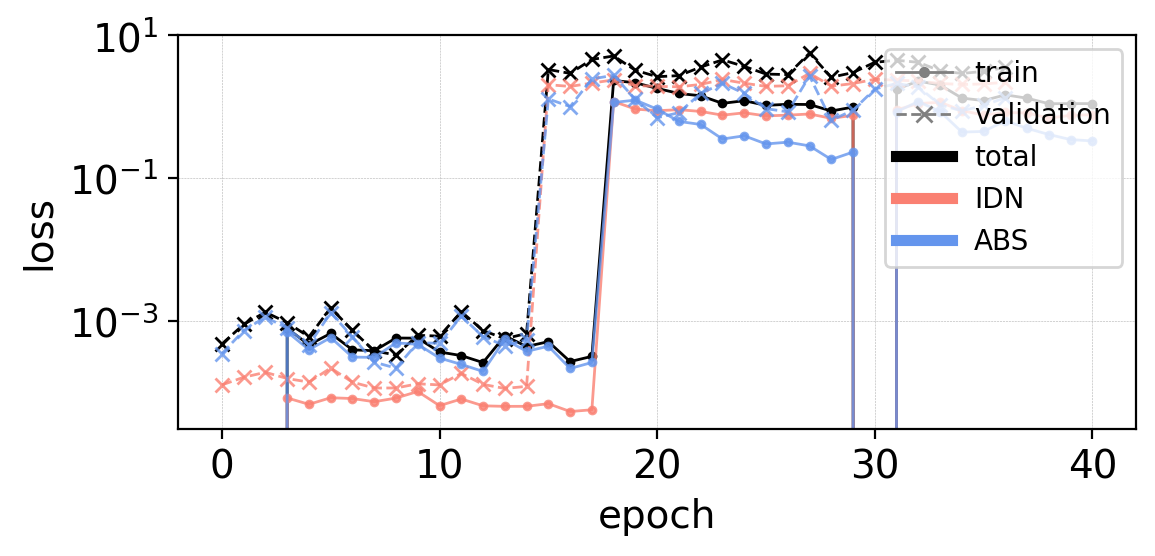

In [52]:
tic = time()
train.train(model,
            data_loader, test_loader,
            start_epochs = input.ini_epochs, end_epochs = input.nb_epochs,
            trainloss=trainloss, testloss=testloss,
            plot = True)
toc = time()
train_time2 = toc-tic

train_time = train_time1 + train_time2

## Saving the model
Save the losses & specifics of the data set.

In [53]:
trainloss.save(path+'/train')
testloss.save(path+'/valid')

min_max = np.stack((traindata.mins, traindata.maxs), axis=1)
np.save(path+'/minmax', min_max)

Save the model and the status of the solver (see [torchode status](https://github.com/martenlienen/torchode/blob/main/torchode/status_codes.py) for more details).

In [54]:
torch.save(model.state_dict(),path+'/nn/nn.pt')

np.save(path+'/train/status', model.get_status('train')) # type: ignore
np.save(path +'/valid/status', model.get_status('test') ) # type: ignore

Plot the evolution of the loss and save the figure.



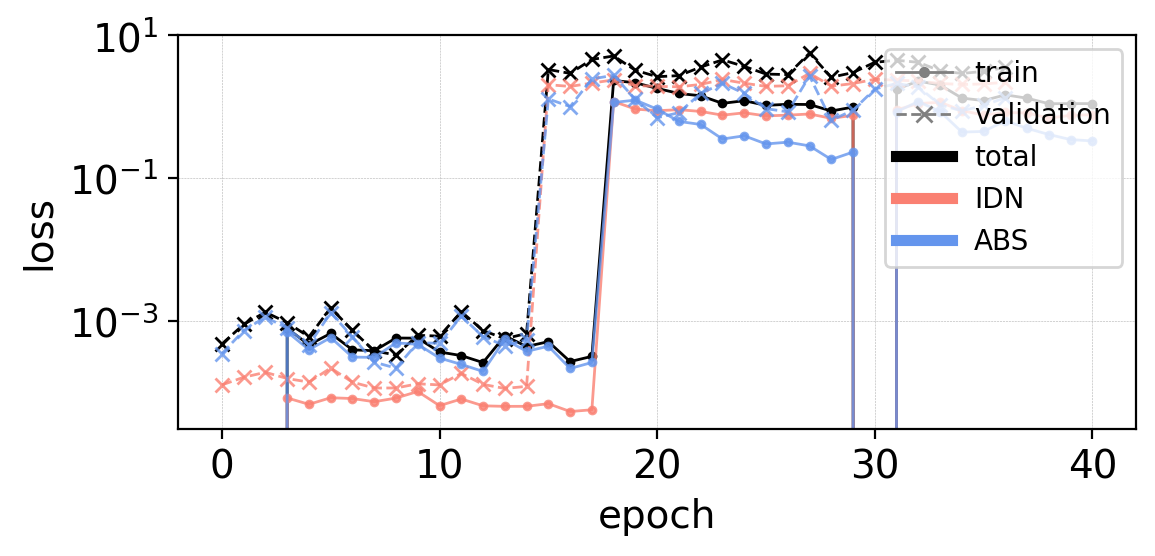

In [55]:
fig_loss = loss.plot(trainloss, testloss, len = input.nb_epochs)
plt.savefig(path+'/loss.png')

## Testing the model


Perform tests on the trained model to get an accuracy indication, according to the following error metric:

$$ {\rm error} = \frac{\log_{10}\boldsymbol{n}-\log_{10}\hat{\boldsymbol{n}}}{\log_{10}\boldsymbol{n}}, $$

which is executed element-wise and subsequently summed over the different chemical species

### Performing the tests

In [58]:
sum_err_step = 0
sum_err_evol = 0

step_calctime = list()
evol_calctime = list()

for i in tqdm(range(len(traindata.testpath))):
#     print(i+1,end='\r')
    testpath = traindata.testpath[i]

    err_test, err_evol, step_time, evol_time = test.test_model(model,testpath, meta, printing = False, inpackage=True, train = True)

    sum_err_step += err_test
    sum_err_evol += err_evol

    step_calctime.append(step_time)
    evol_calctime.append(evol_time)

  0%|          | 0/1 [00:00<?, ?it/s]

> Train state: True
Found paths: 5
Selected paths: 4
Selected test paths: 100


-------------------
Input of test model
-------------------
Mdot [Msol/yr]:       2e-07
v [km/s]:             7.5
Density proxi Mdot/v: 2.666666666666667e-13

Temp at 1e16 cm [K]:  36.13
Tstar:                2800.0
eps:                  0.7
-------------------



100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


### Saving the outcome of the tests
The error saved is normalised over the amount of tests, given by len(traindata.testpath.

In [59]:
utils.makeOutputDir(path+'/test')

np.save(path+ '/test/sum_err_step.npy', np.array(sum_err_step/len(traindata.testpath)))
np.save(path+ '/test/sum_err_evol.npy', np.array(sum_err_evol/len(traindata.testpath)))

np.save(path+ '/test/calctime_evol.npy', evol_calctime)
np.save(path+ '/test/calctime_step.npy', step_calctime)

print('\nAverage error:')
print('           Step:', np.round(sum_err_step,3))
print('      Evolution:', np.round(sum_err_evol,3))


Average error:
           Step: 4.817
      Evolution: 24.773
